In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import set_config

In [92]:
dir_local = set_config.ConfigSectionMap("SectionOne")['local']
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']

In [93]:
def get_col_widths(dataframe):
    # First we find the maximum length of the index column   
    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]


In [94]:
folder='Alarms_data'
filename = 'alarms.csv'
path = os.path.join(dir_sanofi_share, folder, filename)
# parse_dates and index datafram
df = pd.read_csv(path, encoding='UTF-8', parse_dates=True, index_col='Start')
df.sort_index(inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# df = pd.read_csv(r'C:\Users\Raza-PC\Documents\McLaren\Sanofi\Sanofi\alarms.csv')

C:\Users\mark_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [95]:
df.head()

,Message Text (English),Message Text,Duration,Filename,Machine,Significant
Start,,,,,,
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 150001 2021-02-04 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 150001 2021-02-04 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 150001 2021-02-04 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 143822 2021-02-14 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 144135 2021-01-13 K747B14.csv,AL6_Etikettierer,NaN


In [118]:
#Define start and end date for specified time period, number of days is calculated.

start_date = '2021-08-01'
end_date = '2021-09-30'

days = datetime.strptime(end_date, '%Y-%m-%d')-datetime.strptime(start_date, '%Y-%m-%d')
ndays=days.days

# df_dates=df[(df['Start'] >= start_date) & (df['Start'] <= end_date) ]
df_dates=df[(df.index >= start_date) & (df.index <= end_date) ]
# df_dates = df.loc[start_date:end_date]


# df_dates=df_dates[df_dates['Filename'].str.contains(machine)]

In [97]:
folder='IP21'
filename='Alarms_Reader_Messages.xlsx'
path = os.path.join(dir_local, folder, filename)
writer = pd.ExcelWriter(path, engine='xlsxwriter')
for temp_machine in df_dates.Machine.unique():
    temp_df = df_dates[df_dates.Machine.str.contains(temp_machine)]
    grouped = temp_df[['Machine', 'Message Text (English)','Duration']].groupby(['Message Text (English)']).agg({'Duration':'sum', 'Message Text (English)': 'count'})
    # convert Duration secs to mins
    grouped['Duration'] = round (grouped['Duration'] / 60, 0)
    grouped.rename(columns={'Duration':'Duration (mins)'}, inplace=True)
    grouped.rename(columns={'Message Text (English)':'count'}, inplace=True)
    # grouped.nlargest(25, 'Duration')
    grouped.sort_values(by=(['Duration (mins)', 'count']), ascending=False, inplace=True)
    grouped = grouped.nlargest(25, 'Duration (mins)')
    grouped.to_excel(writer, sheet_name=temp_machine)
    # call function get_col_widths to auto size the excel columns
    workbook = writer.book
    worksheet = writer.sheets[temp_machine]
    for x, width in enumerate(get_col_widths(grouped)):
        #set each column width to be 1*25 that of the max string so that it fits nicely
        worksheet.set_column(x, x, width * 1.3)    



df_dates.sort_values(by=['Duration'], ascending=False).reset_index(inplace=True)
df_dates.to_excel(writer, sheet_name='all_messages')
workbook = writer.book
worksheet = writer.sheets['all_messages']
for x, width in enumerate(get_col_widths(grouped)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.3)    
writer.save()

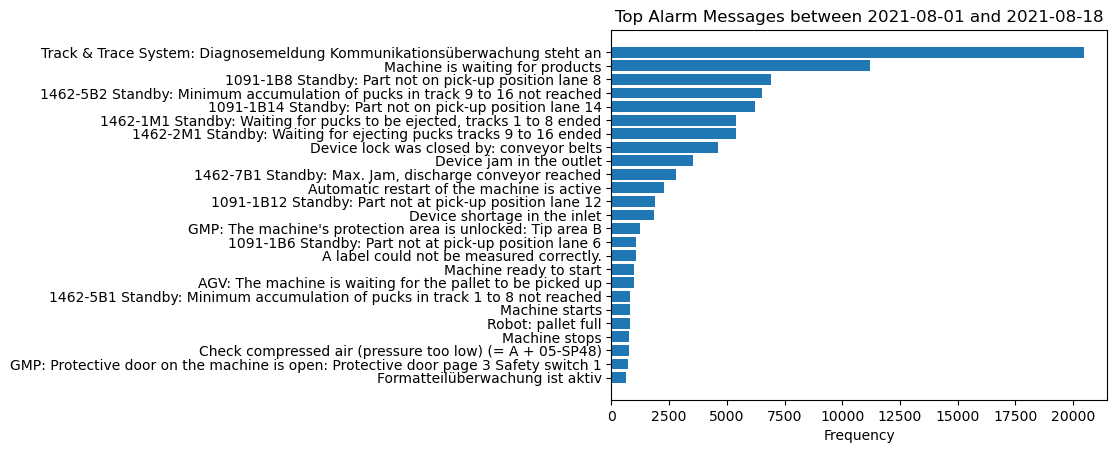

In [98]:
s=df_dates['Message Text (English)'].value_counts()
#Show top 25 alert messages
top=s.nlargest(25)
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
names = (top.index)
y_pos = np.arange(len(names))
performance= top.values

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Top Alarm Messages between {} and {}'.format(start_date, end_date))

plt.show()

In [99]:
#Group data by alert message and calculate mean duration and frequency. Convert duration to minutes.
m=df_dates.groupby('Message Text (English)').agg(['mean', 'count'])
mc = m['Duration']['mean'] * m['Duration']['count'] / (60*ndays)

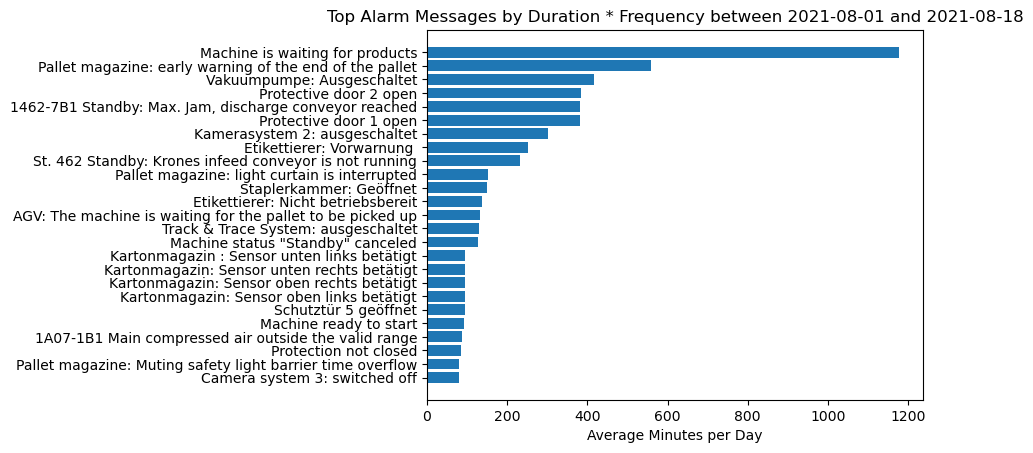

In [100]:
#Plot top 25 most significant error messages.
top=mc.nlargest(25)
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
names = (top.index)
y_pos = np.arange(len(names))
performance= top.values

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Minutes per Day')
ax.set_title('Top Alarm Messages by Duration * Frequency between {} and {}'.format(start_date, end_date))

plt.show()

In [101]:
df_dates.sort_values(by=['Duration'], ascending=False).reset_index(inplace=True)

In [111]:
m

Duration      
                                                           mean count
Message Text (English)                                               
 = A + 52-AP-U1 # AS-i error                         152.000000    12
1005-2B2 Bad parts container not in position          24.000000     1
1010-3B1 End position error gripper track 1 open       7.000000     1
1010-3B2 End position error gripper track 2 open       5.000000     2
1010-3B3 End position error gripper track 3 open       5.000000     2
...                                                         ...   ...
[Q] F4_403 # overload has triggered (= E + 52-S...    38.500000     8
[Q] VT_608 # Sensor error folding box adhesive ...   137.500000     8
[Q] VT_608 # Sensor error folding box adhesive ...    55.500000     8
[Q] VT_608 # Sensor error folding box length OK...    70.000000     8
xxx - parts of the order size reached               1227.857143     7

[692 rows x 2 columns]

Text(0.5, 1.0, 'Count of roll alerts for Etikettierer')

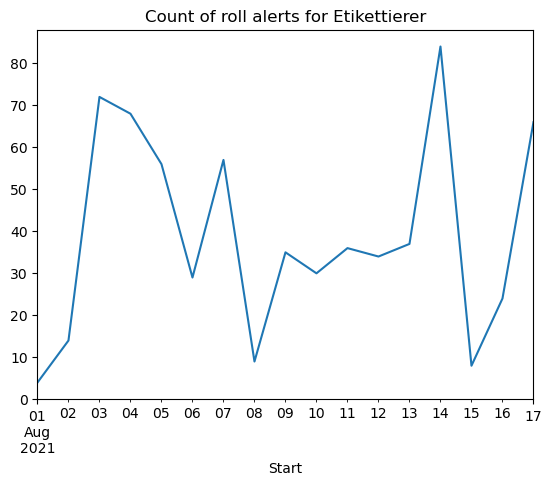

In [88]:
# messages = ['Maschinenzustand "Standby" abgebrochen    0..Flt[100]','1462-7B1 Standby: Max. Stau Abführband erreicht;0..Flt[1198]']

df_label = df_dates[df_dates['Message Text (English)'].str.contains('The label roll')]
df_label.groupby(pd.Grouper(freq='D'))['Message Text (English)'].count().plot()
plt.title('Count of roll alerts for Etikettierer')

In [89]:
df_label.groupby([pd.Grouper(freq='D'), 'Message Text (English)'])['Message Text'].count().reset_index()

,Start,Message Text (English),Message Text
0,2021-08-01,The label roll will soon be empty,4
1,2021-08-02,The label roll is empty,4
2,2021-08-02,The label roll will soon be empty,10
3,2021-08-03,The label roll is empty,16
4,2021-08-03,The label roll will soon be empty,56
5,2021-08-04,The label roll is empty,6
6,2021-08-04,The label roll will soon be empty,62
7,2021-08-05,The label roll is empty,4
8,2021-08-05,The label roll will soon be empty,52
9,2021-08-06,The label roll is empty,4


In [90]:
# write out the Significant_alarms_merged file to the sanofi share
folder='Alarms_data'
filename = 'label_empty.csv'
path = os.path.join(dir_sanofi_share, folder, filename)
df_label.to_csv(path)

Text(0.5, 0, 'Date')

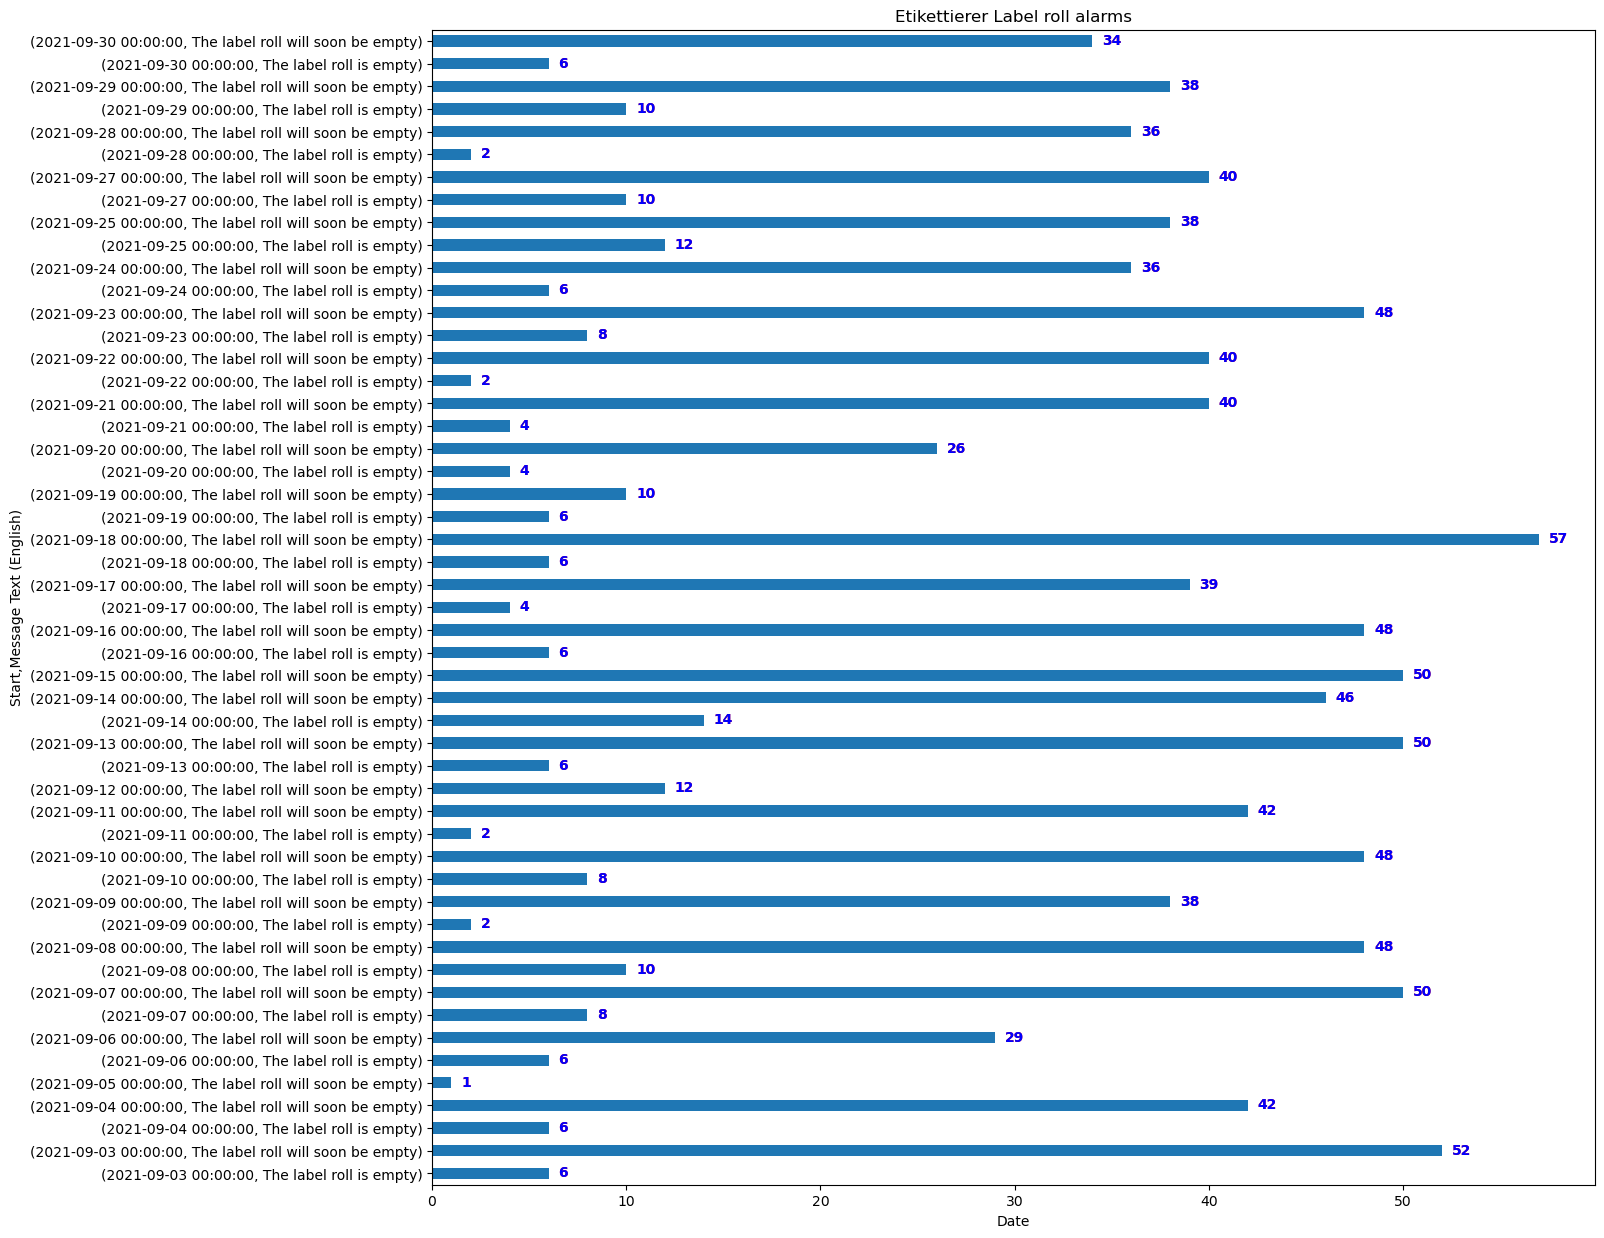

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

df_label['2021-09-03':'2021-09-30'].groupby([pd.Grouper(freq='D'), 'Message Text (English)']).Significant.count().plot.barh(ax=ax)

for i, v in enumerate(df_label['2021-09-03':'2021-09-30'].groupby([pd.Grouper(freq='D'), 'Message Text (English)']).Significant.count()):
    ax.text(v + 0.5, i - .15, str(v), color='red', fontweight='bold')

for i, v in enumerate(df_label['2021-09-03':'2021-09-30'].groupby([pd.Grouper(freq='D'), 'Message Text (English)']).Significant.count()):
    ax.text(v + 0.5, i - .15, str(v), color='blue', fontweight='bold')


ax.set_title('Etikettierer Label roll alarms')
# set the limits
ax.set_xlabel('Date')


# Buffer Alarms

Text(0.5, 1.0, 'Count of roll alerts for Etikettierer')

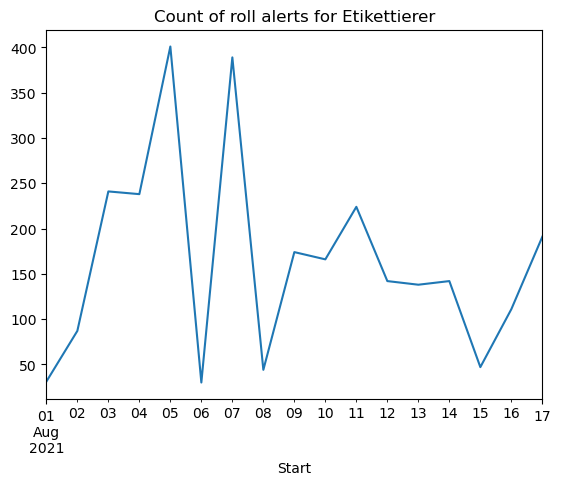

In [103]:
# messages = ['Maschinenzustand "Standby" abgebrochen    0..Flt[100]','1462-7B1 Standby: Max. Stau Abführband erreicht;0..Flt[1198]']

df_buffer = df_dates[df_dates['Message Text (English)'].str.contains('1462-7B1')]
df_buffer.groupby(pd.Grouper(freq='D'))['Message Text (English)'].count().plot()
plt.title('Count of Assembly to Labeller is full')

In [105]:
df_buffer.groupby([pd.Grouper(freq='D'), 'Message Text (English)'])['Message Text'].count().reset_index()

,Start,Message Text (English),Message Text
0,2021-08-01,"1462-7B1 Standby: Max. Jam, discharge conveyor...",31
1,2021-08-02,"1462-7B1 Standby: Max. Jam, discharge conveyor...",87
2,2021-08-03,"1462-7B1 Standby: Max. Jam, discharge conveyor...",241
3,2021-08-04,"1462-7B1 Standby: Max. Jam, discharge conveyor...",238
4,2021-08-05,"1462-7B1 Standby: Max. Jam, discharge conveyor...",401
5,2021-08-06,"1462-7B1 Standby: Max. Jam, discharge conveyor...",30
6,2021-08-07,"1462-7B1 Standby: Max. Jam, discharge conveyor...",389
7,2021-08-08,"1462-7B1 Standby: Max. Jam, discharge conveyor...",44
8,2021-08-09,"1462-7B1 Standby: Max. Jam, discharge conveyor...",174
9,2021-08-10,"1462-7B1 Standby: Max. Jam, discharge conveyor...",166


In [106]:
df_buffer

,Message Text (English),Message Text,Duration,Filename,Machine,Significant
Start,,,,,,
2021-08-01 00:29:02,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,95.0,A210801.TXT,AL6_Montage,Yes
2021-08-01 00:30:56,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,29.0,A210801.TXT,AL6_Montage,Yes
2021-08-01 00:33:37,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,1655.0,A210801.TXT,AL6_Montage,Yes
2021-08-01 01:03:49,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,83.0,A210801.TXT,AL6_Montage,Yes
2021-08-01 01:16:43,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,52.0,A210801.TXT,AL6_Montage,Yes
...,...,...,...,...,...,...
2021-08-17 23:43:04,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,38.0,A210817.TXT,AL6_Montage,Yes
2021-08-17 23:48:52,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,103.0,A210818.TXT,AL6_Montage,Yes
2021-08-17 23:48:52,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,103.0,A210817.TXT,AL6_Montage,Yes


In [119]:
df_dates[df_dates['Message Text (English)'].str.contains('1462-7B1')]

,Message Text (English),Message Text,Duration,Filename,Machine,Significant
Start,,,,,,
2021-08-01 00:29:02,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,95.0,A210801.TXT,AL6_Montage,Yes
2021-08-01 00:30:56,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,29.0,A210801.TXT,AL6_Montage,Yes
2021-08-01 00:33:37,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,1655.0,A210801.TXT,AL6_Montage,Yes
2021-08-01 01:03:49,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,83.0,A210801.TXT,AL6_Montage,Yes
2021-08-01 01:16:43,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,52.0,A210801.TXT,AL6_Montage,Yes
...,...,...,...,...,...,...
2021-09-29 22:24:00,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,129.0,A210929.TXT,AL6_Montage,Yes
2021-09-29 22:26:44,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,254.0,A210929.TXT,AL6_Montage,Yes
2021-09-29 22:31:28,"1462-7B1 Standby: Max. Jam, discharge conveyor...",1462-7B1 Standby: Max. Stau Abführband erreicht,588.0,A210929.TXT,AL6_Montage,Yes


In [120]:
df

,Message Text (English),Message Text,Duration,Filename,Machine,Significant
Start,,,,,,
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 150001 2021-02-04 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 150001 2021-02-04 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 150001 2021-02-04 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 143822 2021-02-14 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 144135 2021-01-13 K747B14.csv,AL6_Etikettierer,NaN
...,...,...,...,...,...,...
NaT,TM_951 # filling position 2 device F4_402: emp...,NaN,NaN,NaN,NaN,Yes
NaT,F2_224 # is started / fault,NaN,NaN,NaN,NaN,No
NaT,Balance: Printouts can no longer be saved loca...,NaN,NaN,NaN,NaN,No
